In [1]:
import jax
import jax.numpy as jnp
import numpyro

numpyro.set_host_device_count(2)
numpyro.set_platform("cpu")  # For CPU (use "gpu" for GPU)
jax.config.update(
    "jax_enable_x64", True
)

import equinox
import matplotlib.pyplot as plt

from numpyro_ext import optim as optimx
from numpyro_ext import distributions as distx

/Users/daniel/code/hoku/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


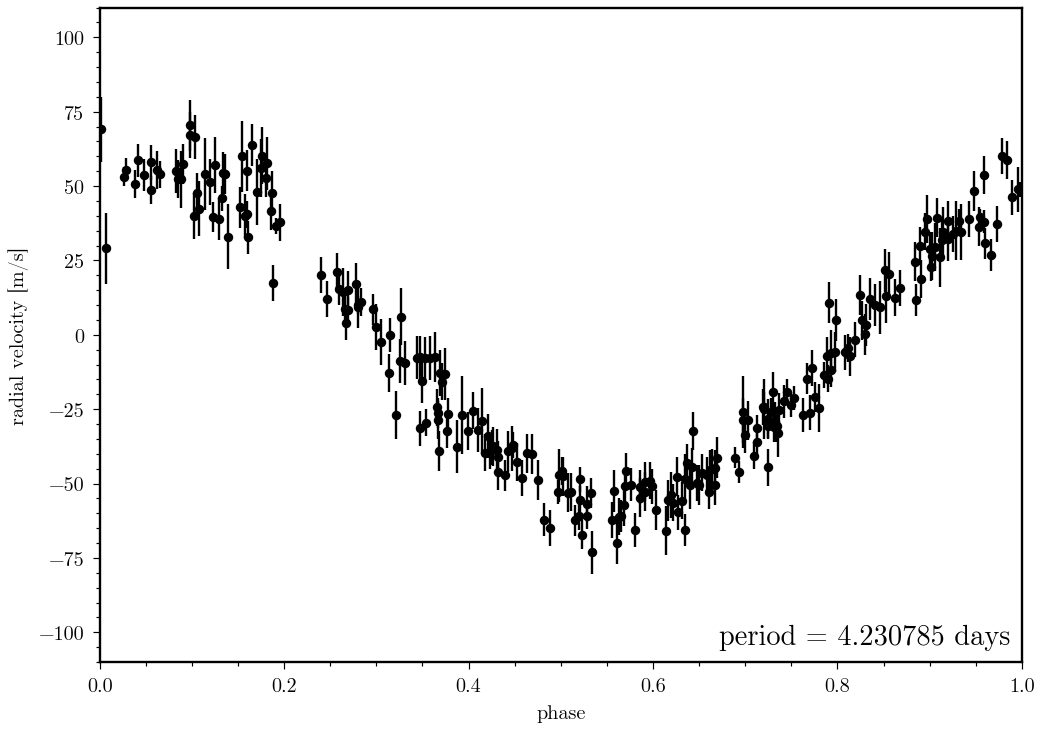

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Download the dataset from the Exoplanet Archive:
url = "https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0113/0113357/data/UID_0113357_RVC_001.tbl"
r = requests.get(url)
if r.status_code != requests.codes.ok:
    r.raise_for_status()
data = np.array(
    [
        l.split()
        for l in r.text.splitlines()
        if not l.startswith("\\") and not l.startswith("|")
    ],
    dtype=float,
)
t, rv, rv_err = data.T
t -= np.mean(t)

# Plot the observations "folded" on the published period:
# Butler et al. (2006) https://arxiv.org/abs/astro-ph/0607493
lit_period = 4.230785
plt.errorbar(
    (t % lit_period) / lit_period, rv, yerr=rv_err, fmt=".k", capsize=0
)
plt.xlim(0, 1)
plt.ylim(-110, 110)
plt.annotate(
    "period = {0:.6f} days".format(lit_period),
    xy=(1, 0),
    xycoords="axes fraction",
    xytext=(-5, 5),
    textcoords="offset points",
    ha="right",
    va="bottom",
    fontsize=12,
)
plt.ylabel("radial velocity [m/s]")
_ = plt.xlabel("phase")

Let's construct a radial velocity model from which we can sample:

In [3]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from hoku.orbits import Orbit

def model(x, yerr, y=None):
    # Priors for the slope and intercept
    period = numpyro.sample("period", dist.Normal(lit_period, 0.1))
    log_jitter = numpyro.sample("log_jitter", dist.Normal(jnp.log(jnp.mean(yerr)), 10))

    ecc = numpyro.sample('ecc', distx.UnitDisk())
    eccen = numpyro.deterministic('eccen', jnp.sum(ecc**2))
    omega = numpyro.sample("omega", distx.Angle())
    phi = numpyro.sample("phi", distx.Angle())

    # t_periastron = numpyro.sample('t_periastron', dist.)
    
    logK = numpyro.sample(
        "logK", dist.Uniform(0, jnp.log(200))
    )
    K = numpyro.deterministic('K', jnp.exp(logK))

    n = 2 * jnp.pi * (-1*period)
    t0 = numpyro.deterministic('t0', (phi + omega) / n)

    # Equinox model for the orbit
    orbit = Orbit(period = period,
                  t_periastron=t0,
                  omega=omega,
                  ecc=eccen)
    tref = numpyro.deterministic('tref', orbit.t0)

    # Add an RV trend
    rv0 = numpyro.sample('rv0', dist.Normal(0, 10))
    rvtrend = numpyro.sample('rvtrend', dist.Normal(0, 10))
    bkg = numpyro.deterministic("bkg", rv0 + rvtrend * x / 365.25)

    # Get the radial velocity of the primary
    y_pred = orbit.get_radial_velocity(x, K)

    # Store it
    numpyro.deterministic('pred', y_pred)
    
    with numpyro.plate('data', len(x)):
        # Likelihood (Gaussian noise)
        numpyro.sample("obs", dist.Normal(y_pred + bkg, yerr**2 + jnp.exp(2 * log_jitter)), obs=y)
    

In [4]:
key = jax.random.PRNGKey(0)

soln = optimx.optimize(
    model,
    # sites=['phi'],
    return_info=False,
)(key, t, rv_err, y=rv)

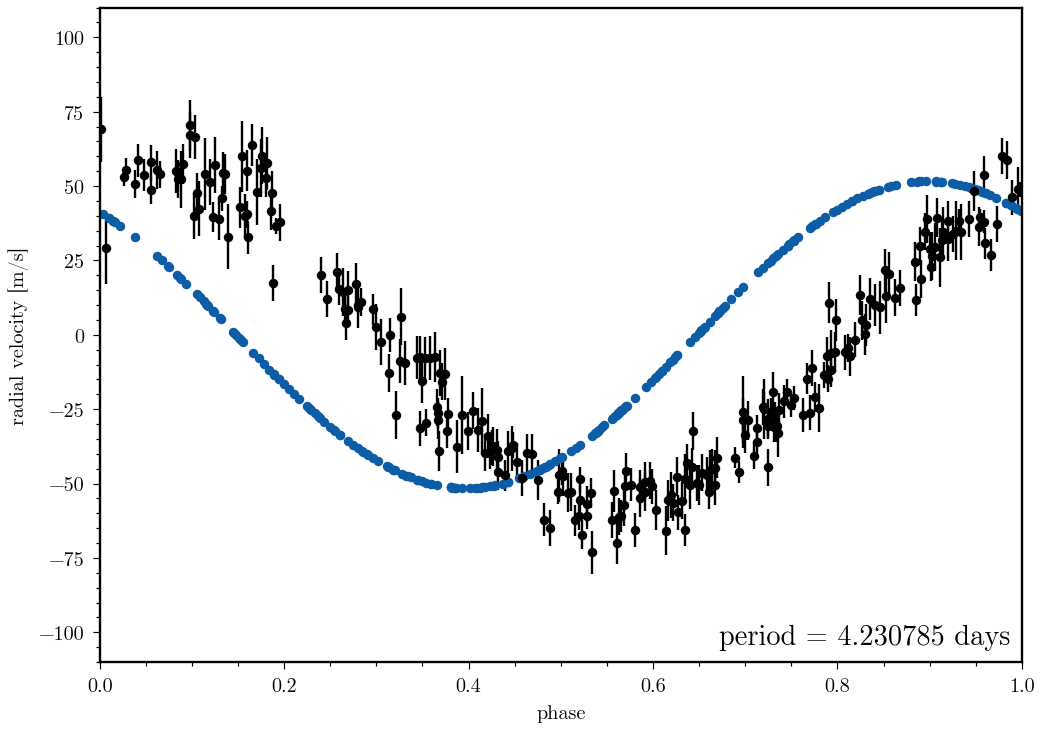

In [5]:
plt.errorbar(
    ((t) % lit_period) / lit_period, rv, yerr=rv_err, fmt=".k", capsize=0
)
plt.xlim(0, 1)
plt.ylim(-110, 110)
plt.annotate(
    "period = {0:.6f} days".format(lit_period),
    xy=(1, 0),
    xycoords="axes fraction",
    xytext=(-5, 5),
    textcoords="offset points",
    ha="right",
    va="bottom",
    fontsize=12,
)
plt.ylabel("radial velocity [m/s]")
_ = plt.xlabel("phase")

# Now let's overplot the initial solution:
# plt.plot((t) % soln['period'] / soln['period'], soln['pred'], '.')
plt.plot((t) % (soln['period']) / soln['period'], soln['pred'], '.')
# plt.plot(t, )
# plt.plot(t % soln['period'] / soln['period'], soln['pred'], '.')

In [6]:
soln['phi']

Array(1.82998629, dtype=float64)

In [7]:
from numpyro import infer

nuts_kernel = infer.NUTS(
    model,
    # target_accept_prob=0.9,
    # dense_mass=True,
    init_strategy=infer.init_to_value(values=soln),
    # regularize_mass_matrix=False,
    # max_tree_depth=10
)
sampler = infer.MCMC(
    nuts_kernel,
    num_warmup=2000,
    num_samples=7000,
    num_chains=2,
    progress_bar=True,
    jit_model_args=True
)

sampler.run(jax.random.PRNGKey(42), t, rv_err, y=rv)

Running chain 0:   0%|          | 0/9000 [00:01<?, ?it/s]

In [10]:
sampler.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
      ecc[0]      0.00      0.13     -0.00     -0.22      0.21   8692.65      1.00
      ecc[1]      0.00      0.14      0.00     -0.23      0.22   9234.00      1.00
        logK      3.94      0.05      3.94      3.86      4.03   9208.21      1.00
  log_jitter     -7.88      5.56     -6.70    -15.88     -0.50   4008.53      1.00
       omega      0.61      0.11      0.61      0.44      0.79   1633.25      1.00
      period      4.22      0.00      4.22      4.22      4.22  13113.96      1.00
         phi      0.04      1.82      0.07     -2.69      2.95   1372.61      1.00
         rv0     -2.15      1.86     -2.17     -5.07      1.06   8883.01      1.00
     rvtrend     -2.05      1.03     -2.04     -3.78     -0.40  10556.81      1.00

Number of divergences: 0


Two ways to visualize, either infer over the model or just plot some random samples from the trace we just built.

In [11]:
samples = sampler.get_samples()

rv_grid = np.linspace(0, lit_period, 1000)
posterior_rvs = infer.Predictive(model, samples)(jax.random.PRNGKey(0), rv_grid, jnp.zeros_like(rv_grid))["obs"]

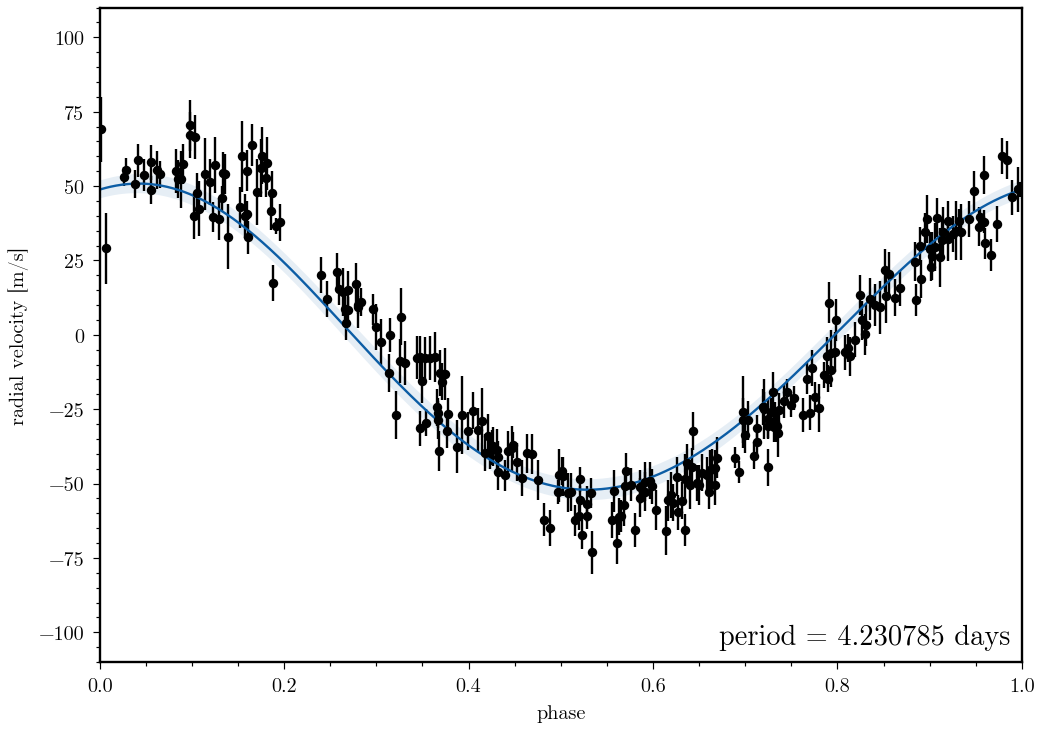

In [15]:
P = samples['period'].mean()
t0 = samples['tref'].mean()

plt.errorbar(
    ((t) % lit_period) / lit_period, rv, yerr=rv_err, fmt=".k", capsize=0
)
plt.xlim(0, 1)
plt.ylim(-110, 110)
plt.annotate(
    "period = {0:.6f} days".format(lit_period),
    xy=(1, 0),
    xycoords="axes fraction",
    xytext=(-5, 5),
    textcoords="offset points",
    ha="right",
    va="bottom",
    fontsize=12,
)
plt.ylabel("radial velocity [m/s]")
_ = plt.xlabel("phase")


x_fold = (rv_grid + t0) % P / P
# x_fold = ((ms.time_mid + time) + (samp['phi'] * samp['period'] / (2*np.pi)))
m = np.argsort(x_fold)

mean_model = posterior_rvs.mean(axis=0)
std_model = posterior_rvs.std(axis=0)
plt.plot(x_fold[m], mean_model[m], c='C0', lw=1)
plt.fill_between(x_fold[m], 
                 (mean_model - std_model)[m],
                 (mean_model + std_model)[m],
                 alpha=0.1
)

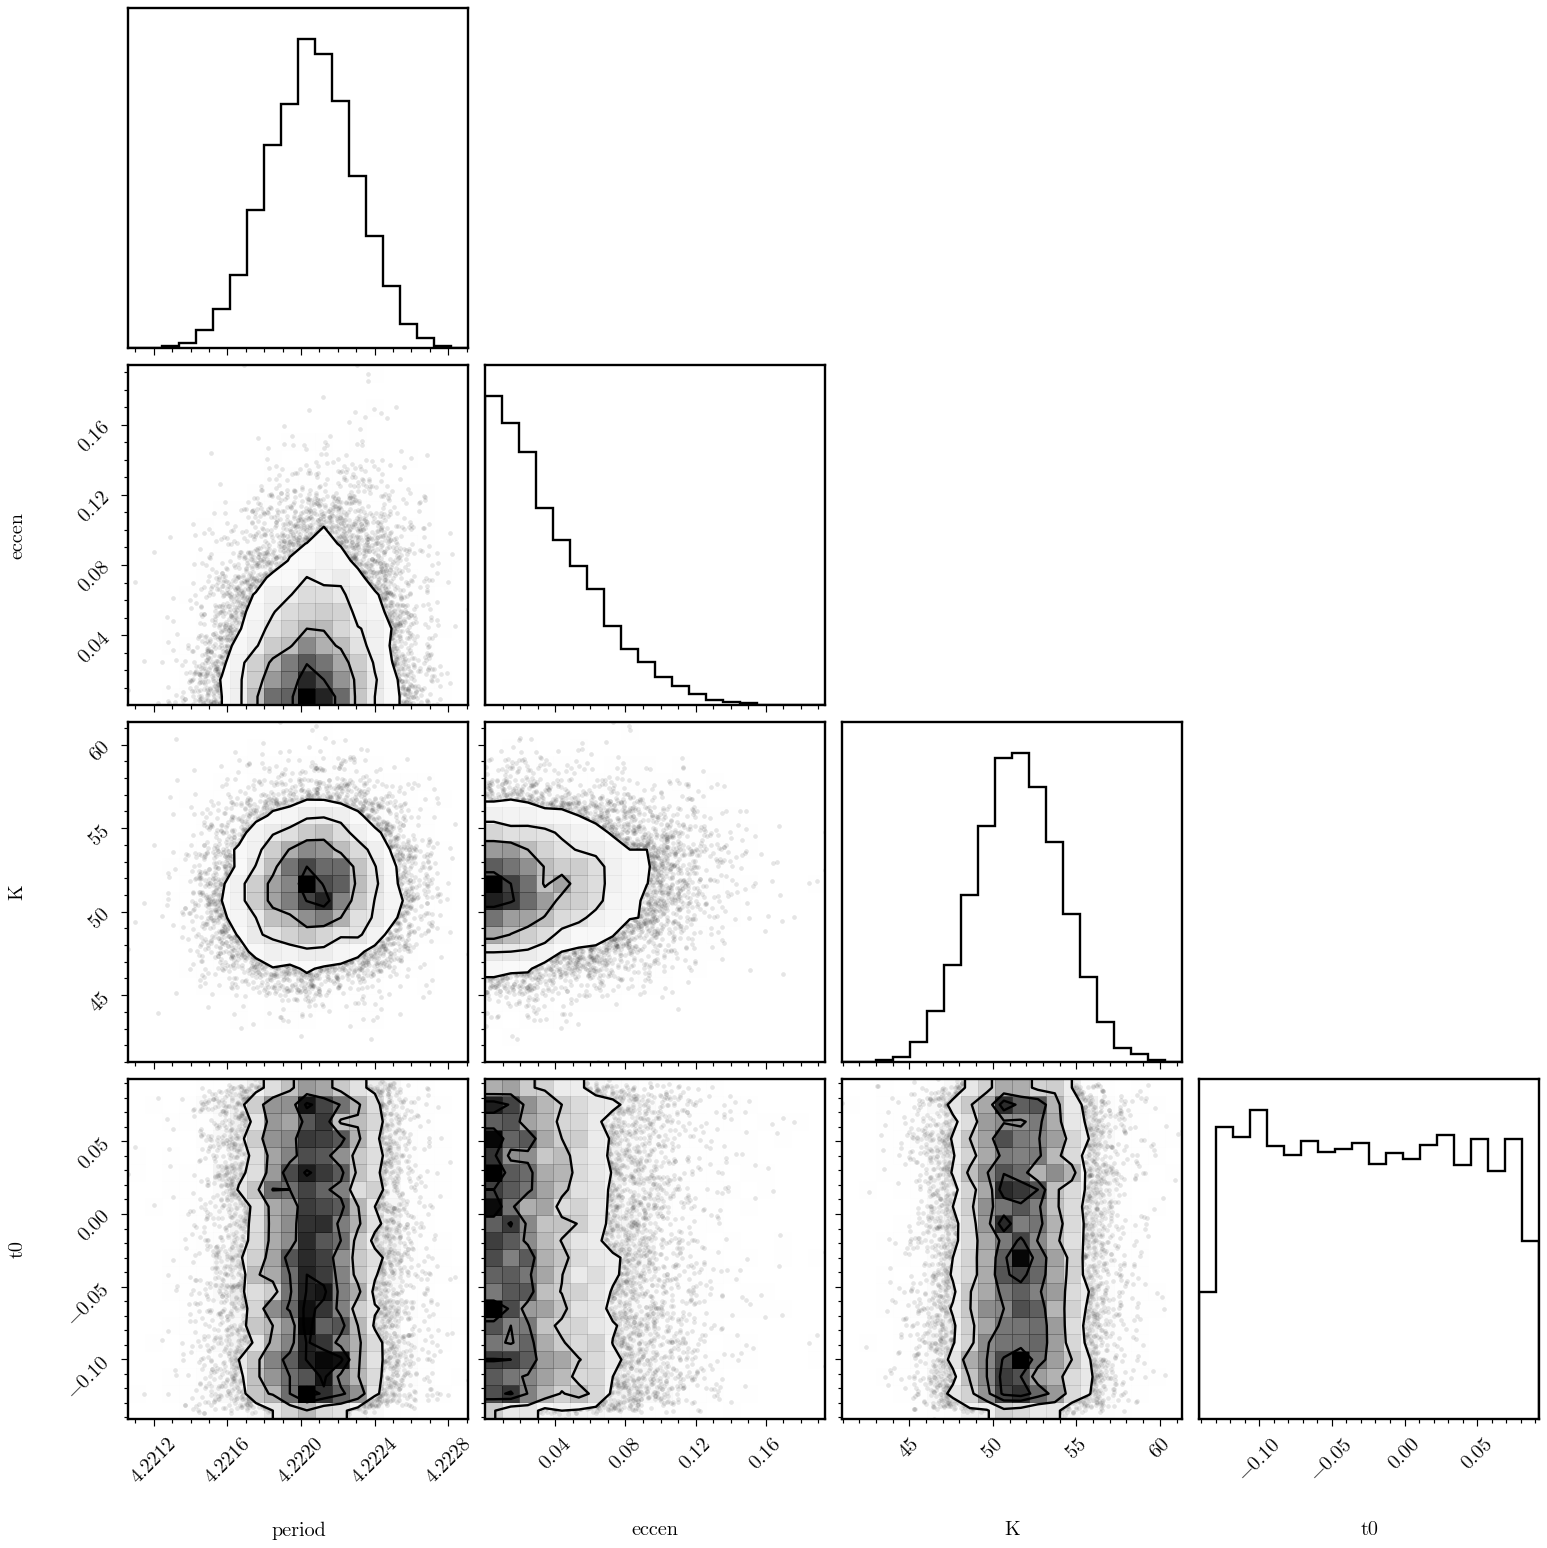

In [17]:
import corner

corner.corner(
    sampler,
    var_names=["period", "eccen", "K", "t0"]
);

In [37]:
import arviz as az

az.summary(az.from_numpyro(sampler), var_names=["t0", "period", "eccen", "K", "phi"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t0,-0.028,0.064,-0.134,0.076,0.002,0.002,795.0,2415.0,1.0
period,4.222,0.000,4.222,4.223,0.000,0.000,10144.0,6544.0,1.0
eccen,0.037,0.028,0.000,0.088,0.000,0.000,6248.0,6764.0,1.0
K,51.550,2.532,46.799,56.332,0.032,0.023,6087.0,6146.0,1.0
phi,0.129,1.807,-2.720,3.125,0.066,0.047,776.0,2446.0,1.0
